# **Backend**

In [ ]:
# 1. Instalar dependencias necesarias para el servidor y el túnel
!pip install flask flask-cors pyngrok tensorflow pillow flask_cors

In [ ]:
NGROK_AUTH_TOKEN = "368NeLEduhFM1ptMxZ5GhF9wZKr_3w7pN9NYRaWrJzAKVNXy"  # 🔒 Cambia el token


In [ ]:
import threading
from flask import Flask, request, jsonify
from flask_cors import CORS
from pyngrok import ngrok
import tensorflow as tf
import numpy as np
from PIL import Image
import io
import keras

# ==============================================================
# CONFIGURACIÓN
# ==============================================================
# 🔒 COLOCA TU TOKEN DE NGROK AQUÍ
NGROK_AUTH_TOKEN = "368NeLEduhFM1ptMxZ5GhF9wZKr_3w7pN9NYRaWrJzAKVNXy"  # 🔒 Cambia el token


MODEL_PATH = "modelo_final_neumonia.keras"
# CAMBIO CLAVE: Usamos 224 para modelos modernos (EfficientNet/DenseNet)
IMG_SIZE = (224, 224)

if NGROK_AUTH_TOKEN:
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)

app = Flask(__name__)
CORS(app)

# ==============================================================
# CARGAR EL MODELO CON SOPORTE PARA CAPAS PERSONALIZADAS
# ==============================================================
print(">>> Cargando modelo inteligente...")

# Importamos las funciones de preprocesamiento por si el modelo las usa internamente
from tensorflow.keras.applications.densenet import preprocess_input as dense_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

# Scope para cargar funciones Lambda guardadas en el .keras
custom_objects = {
    'preprocess_input': dense_preprocess # En caso de que DenseNet haya ganado
}

try:
    with tf.keras.utils.custom_object_scope(custom_objects):
        model = tf.keras.models.load_model(MODEL_PATH)

    print(">>> ¡Modelo cargado exitosamente!")
    model.summary()
except Exception as e:
    print(f"ERROR CRÍTICO: No se pudo cargar el modelo. {e}")
    model = None

# ==============================================================
# RUTA DE PREDICCIÓN (API)
# ==============================================================
@app.route("/predict", methods=["POST"])
def predict():
    if not model:
        return jsonify({"error": "Modelo no disponible"}), 500

    if "file" not in request.files:
        return jsonify({"error": "No imagen enviada"}), 400

    file = request.files["file"]

    try:
        # 1. Preprocesamiento Básico
        img = Image.open(io.BytesIO(file.read())).convert("RGB")
        img = img.resize(IMG_SIZE) # 224x224

        # 2. Convertir a Array "Crudo" (0-255)
        # NO dividir por 255 aquí. El modelo tiene la capa interna para eso.
        img_array = np.array(img).astype("float32")
        input_data = np.expand_dims(img_array, axis=0)

        # 3. Predicción
        prediction = model.predict(input_data)[0][0]

        # 4. Lógica de Diagnóstico
        diagnosis = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
        confidence = prediction if diagnosis == "PNEUMONIA" else (1 - prediction)

        return jsonify({
            "diagnosis": diagnosis,
            "confidence": f"{confidence * 100:.2f}%",
            "raw_score": float(prediction)
        })

    except Exception as e:
        print("Error en predicción:", e)
        return jsonify({"error": str(e)}), 500

@app.route("/", methods=["GET"])
def home():
    return "API MediScan AI (EfficientNet/DenseNet) Activa."

# ==============================================================
# INICIAR SERVIDOR
# ==============================================================
def start_ngrok():
    ngrok.kill()
    try:
        url = ngrok.connect(5000).public_url
        print(f"\n --- URL PÚBLICA: {url} ---\n")
    except Exception as e:
        print("Error Ngrok:", e)

if __name__ == "__main__":
    threading.Thread(target=start_ngrok).start()
    app.run(port=5000, debug=False, use_reloader=False)

>>> Cargando modelo inteligente...
>>> ¡Modelo cargado exitosamente!


Model: "DenseNet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,048,773 (26.89 MB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)

 Optimizer params: 6,148 (24.02 KB)

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit



 --- URL PÚBLICA: https://practic-thomasine-waggishly.ngrok-free.dev ---

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


INFO:werkzeug:127.0.0.1 - - [30/Nov/2025 17:56:53] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


INFO:werkzeug:127.0.0.1 - - [30/Nov/2025 17:57:12] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


INFO:werkzeug:127.0.0.1 - - [30/Nov/2025 17:57:24] "POST /predict HTTP/1.1" 200 -


# **Proyecto**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
>>> Cargando Datasets...
Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.

--- Entrenando Modelo A: EfficientNetB0 ---
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/8
326/326 ━━━━━━━━━━━━━━━━━━━━ 641s 2s/step - accuracy: 0.8409 - loss: 0.3594 - val_accuracy: 0.8061 - val_loss: 0.4077
Epoch 2/8
326/326 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.9181 - loss: 0.2050 - val_accuracy: 0.8494 - val_loss: 0.3608
Epoch 3/8
326/326 ━━━━━━━━━━━━━━━━━━━━ 531s 2s/step - accuracy: 0.9213 - loss: 0.1944 - val_accuracy: 0.8702 - val_loss: 0.3071
Epoch 4/8
326/326 ━━━━━━━━━━━━━━━━━━━━ 560s 2s/step - accuracy: 0.9232 - loss: 0.1856 - val_accuracy: 0.8686 - val_loss: 0.3274
Epoch 5/8
326/326 ━━━━━━━━━━━━━━━━━━━━ 525s 2s/step - accuracy: 0.9137 - loss: 0.2128 - val_accuracy: 0.8718 - val_los

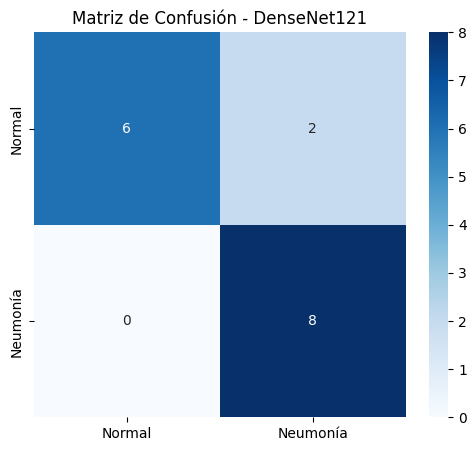

In [ ]:
# ================================================================
#    PROYECTO: Diagnóstico de Neumonía (EfficientNet vs DenseNet)
#    OPTIMIZADO PARA ALTA PRECISIÓN EN COLAB FREE
# ================================================================

# 1. IMPORTS & SETUP
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, Input, applications, callbacks
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from google.colab import drive

# Configuración para evitar errores de memoria
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

# 2. MONTAR DRIVE
drive.mount('/content/drive')

# RUTAS
base_dir = "/content/drive/MyDrive/Proyecto Computacion inteligente/chest_xray"
save_dir = "/content/drive/MyDrive/Proyecto Computacion inteligente"

train_dir = os.path.join(base_dir, "train")
test_dir  = os.path.join(base_dir, "test")
val_dir   = os.path.join(base_dir, "val")

# 3. CARGA DE DATOS (PIPELINE)
# ----------------------------------------------------------------
# NOTA: Usamos 224x224 porque EfficientNet y DenseNet rinden mejor
# con un poco más de resolución que 160x160.
# ----------------------------------------------------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 16 # Bajamos a 16 para que DenseNet quepa en la memoria RAM de Colab
AUTOTUNE = tf.data.AUTOTUNE

def load_dataset(path, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        label_mode="binary",
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=shuffle,
        seed=42
    )
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

print(">>> Cargando Datasets...")
train_ds = load_dataset(train_dir, shuffle=True)
test_ds  = load_dataset(test_dir, shuffle=False)
val_ds   = load_dataset(val_dir, shuffle=False)

# 4. DATA AUGMENTATION (Para evitar overfitting)
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

# ================================================================
# 5. DEFINICIÓN DE MODELOS (MODERNOS & EFICIENTES)
# ================================================================

# --- OPCIÓN 1: EFFICIENTNET B0 ---
# Nota: EfficientNet espera valores 0-255 por defecto (ya trae escalado interno).
def build_efficientnet():
    base_model = applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False # Transfer Learning: Congelar base

    inputs = Input(shape=(224, 224, 3))
    x = data_aug(inputs)
    # EfficientNet maneja el preprocesamiento internamente, no agregamos Lambda
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs, outputs, name="EfficientNetB0")

# --- OPCIÓN 2: DENSENET 121 (El estándar médico) ---
# Nota: DenseNet requiere un preprocesamiento específico (escalado y normalización).
# Lo incrustamos DENTRO del modelo usando Lambda para que el Backend sea simple.
def build_densenet():
    preprocess_func = applications.densenet.preprocess_input

    base_model = applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    inputs = Input(shape=(224, 224, 3))
    x = data_aug(inputs)
    # Incrustamos la matemática de preprocesamiento aquí:
    x = layers.Lambda(preprocess_func)(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs, outputs, name="DenseNet121")

# 6. ENTRENAMIENTO COMPARATIVO (PARTE B DEL PDF)
EPOCHS = 8 # EfficientNet aprende rápido
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\n--- Entrenando Modelo A: EfficientNetB0 ---")
model_a = build_efficientnet()
model_a.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_a = model_a.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stop])

print("\n--- Entrenando Modelo B: DenseNet121 ---")
model_b = build_densenet()
model_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_b = model_b.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stop])

# 7. SELECCIÓN DEL GANADOR
acc_a = max(hist_a.history['val_accuracy'])
acc_b = max(hist_b.history['val_accuracy'])

print(f"\nResultados:\nEfficientNetB0: {acc_a:.4f}\nDenseNet121:    {acc_b:.4f}")

if acc_a > acc_b:
    best_name = "EfficientNetB0"
    best_builder = build_efficientnet
    print(f">>> GANADOR: {best_name}")
else:
    best_name = "DenseNet121"
    best_builder = build_densenet
    print(f">>> GANADOR: {best_name}")

# 8. ENTRENAMIENTO FINAL (PARTE C DEL PDF - REQUISITO ESTRICTO)
# "Una el conjunto de entrenamiento y prueba, y evalúe en validación"
print("\n>>> Generando Dataset Final (Train + Test)...")
full_train_ds = train_ds.concatenate(test_ds)
full_train_ds = full_train_ds.shuffle(2000).prefetch(AUTOTUNE)

print(f">>> Re-entrenando {best_name} con TODOS los datos...")
final_model = best_builder()

# Usamos un learning rate pequeño para el ajuste fino final
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

final_hist = final_model.fit(
    full_train_ds,
    validation_data=val_ds,
    epochs=EPOCHS + 2, # Un par de épocas extra
    callbacks=[early_stop]
)

# 9. GUARDAR MODELO
model_path = os.path.join(save_dir, "modelo_final_neumonia.keras")
final_model.save(model_path)
print(f"\n>>> Modelo guardado en: {model_path}")

# 10. EVALUACIÓN FINAL & REQUISITOS (Matriz, F1, Precision)
y_true = []
y_pred_probs = []

print(">>> Evaluando métricas finales...")
for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(final_model.predict(images, verbose=0))

y_true = np.array(y_true).flatten()
y_pred = (np.array(y_pred_probs).flatten() > 0.5).astype(int)

print("\n" + "="*30)
print(f"REPORTE FINAL ({best_name})")
print("="*30)
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")

# Gráficas requeridas
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Neumonía'], yticklabels=['Normal', 'Neumonía'])
plt.title(f'Matriz de Confusión - {best_name}')
plt.show()

>>> Cargando modelo desde: /content/drive/MyDrive/Proyecto Computacion inteligente/modelo_final_neumonia.keras
>>> ¡Modelo cargado exitosamente!
>>> Cargando imágenes de validación...
Found 16 files belonging to 2 classes.
>>> Generando predicciones...

 VISUALIZACIÓN DE RESULTADOS (Punto D)


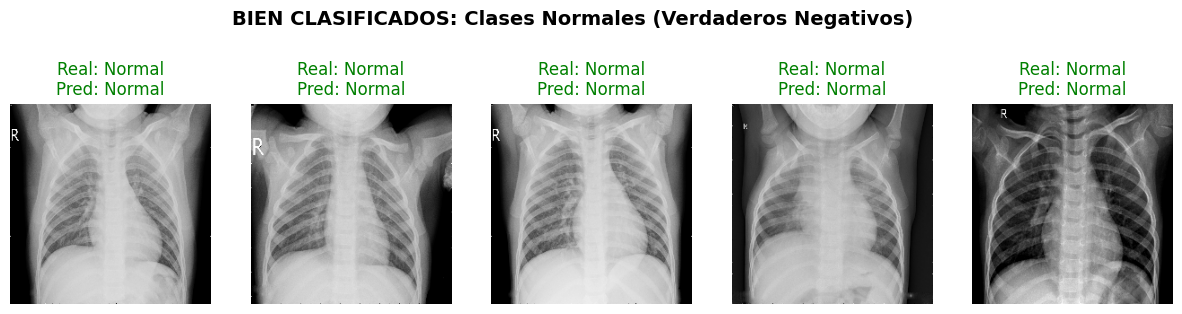

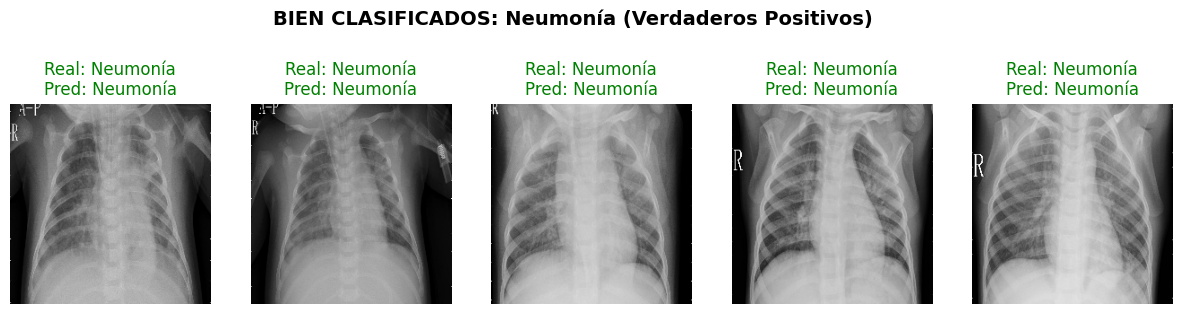

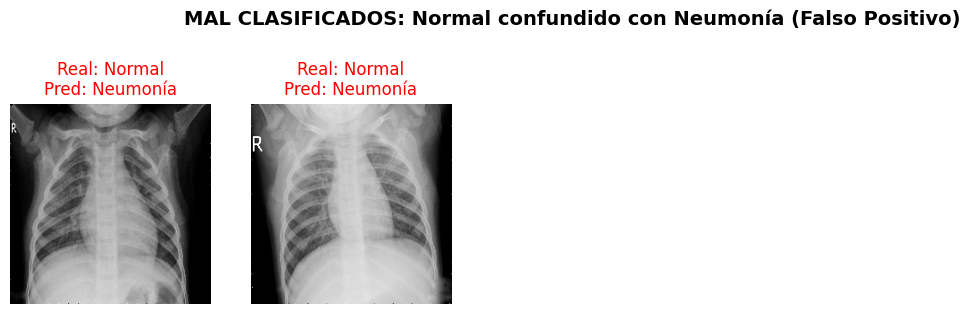


[INFO] No se encontraron ejemplos para: MAL CLASIFICADOS: Neumonía confundida con Normal (Falso Negativo)


In [ ]:
# ================================================================
#  PUNTO D: ANÁLISIS DE RESULTADOS Y VISUALIZACIÓN DE ERRORES
#  (Ejecutar en celda independiente)
# ================================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import applications
from google.colab import drive

# 1. PREPARACIÓN DEL ENTORNO
# ----------------------------------------------------------------
# Montamos Drive nuevamente por si esta es una sesión nueva
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Rutas (Asegúrate de que coincidan con las que usaste al entrenar)
base_dir = "/content/drive/MyDrive/Proyecto Computacion inteligente/chest_xray"
val_dir   = os.path.join(base_dir, "val")
save_dir = "/content/drive/MyDrive/Proyecto Computacion inteligente"
model_path = os.path.join(save_dir, "modelo_final_neumonia.keras")

# 2. CARGAR EL MEJOR MODELO GUARDADO
# ----------------------------------------------------------------
print(f">>> Cargando modelo desde: {model_path}")

# Necesitamos definir 'preprocess_input' por si el modelo guardado es DenseNet
# y usa la función dentro de una capa Lambda.
custom_objects = {
    'preprocess_input': applications.densenet.preprocess_input
}

try:
    with tf.keras.utils.custom_object_scope(custom_objects):
        final_model = tf.keras.models.load_model(model_path)
    print(">>> ¡Modelo cargado exitosamente!")
except Exception as e:
    print(f"Error al cargar el modelo: {e}")
    print("Asegúrate de haber ejecutado el entrenamiento y guardado el modelo .keras primero.")

# 3. CARGAR DATOS DE VALIDACIÓN
# ----------------------------------------------------------------
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

print(">>> Cargando imágenes de validación...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False  # Importante: No mezclar para mantener orden al visualizar
)

# 4. GENERAR PREDICCIONES Y CLASIFICAR
# ----------------------------------------------------------------
all_images = []
all_labels = []
all_preds = []

print(">>> Generando predicciones...")
for images, labels in val_ds:
    # Predicción del modelo
    preds = final_model.predict(images, verbose=0)

    # Guardamos datos en listas
    all_images.extend(images.numpy().astype("uint8")) # Convertir a entero para visualización
    all_labels.extend(labels.numpy().flatten().astype(int))
    all_preds.extend((preds > 0.5).astype(int).flatten())

# Convertir a arrays numpy para facilitar filtrado
all_images = np.array(all_images)
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Nombres de clases (0: NORMAL, 1: PNEUMONIA según orden alfabético)
class_names = ['Normal', 'Neumonía']

# 5. FILTRADO DE CASOS (ACIERTOS Y ERRORES)
# ----------------------------------------------------------------
# Índices según el caso
idx_correct_normal = np.where((all_labels == 0) & (all_preds == 0))[0]
idx_correct_pneumonia = np.where((all_labels == 1) & (all_preds == 1))[0]

idx_error_falso_pneumonia = np.where((all_labels == 0) & (all_preds == 1))[0] # Era Normal, dijo Neumonía
idx_error_falso_normal = np.where((all_labels == 1) & (all_preds == 0))[0]    # Era Neumonía, dijo Normal

# 6. FUNCIÓN DE PLOTEO
# ----------------------------------------------------------------
def plot_cases(indices, title, max_imgs=5):
    if len(indices) == 0:
        print(f"\n[INFO] No se encontraron ejemplos para: {title}")
        return

    count = min(len(indices), max_imgs)
    plt.figure(figsize=(15, 4))
    plt.suptitle(title, fontsize=14, fontweight='bold')

    for i in range(count):
        idx = indices[i]
        ax = plt.subplot(1, max_imgs, i + 1)
        plt.imshow(all_images[idx])

        real = class_names[all_labels[idx]]
        pred = class_names[all_preds[idx]]

        # Color del título: Verde si acierta, Rojo si falla
        color = 'green' if real == pred else 'red'

        plt.title(f"Real: {real}\nPred: {pred}", color=color)
        plt.axis("off")
    plt.show()

# 7. MOSTRAR RESULTADOS (PUNTO D DEL PDF)
# ----------------------------------------------------------------
print("\n" + "="*50)
print(" VISUALIZACIÓN DE RESULTADOS (Punto D)")
print("="*50)

# Aciertos
plot_cases(idx_correct_normal, "BIEN CLASIFICADOS: Clases Normales (Verdaderos Negativos)")
plot_cases(idx_correct_pneumonia, "BIEN CLASIFICADOS: Neumonía (Verdaderos Positivos)")

# Errores
plot_cases(idx_error_falso_pneumonia, "MAL CLASIFICADOS: Normal confundido con Neumonía (Falso Positivo)")
plot_cases(idx_error_falso_normal, "MAL CLASIFICADOS: Neumonía confundida con Normal (Falso Negativo)")